In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import time
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
train_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\dataset"
validation_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\Split\\validasi"

In [3]:
# Tanpa augmentasi, hanya preprocessing dari EfficientNetV2B3
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# Load data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 163 images belonging to 12 classes.


In [6]:
# ImageDataGenerator untuk data validasi (tanpa augmentasi)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load data validasi
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 720 images belonging to 12 classes.


In [7]:
# # Nama kelas
# classes = ['Nose', 'Nose Disease']

# # Plot untuk menampilkan hasil
# plt.figure(figsize=(12, 18))

# for idx, class_name in enumerate(classes):
#     # Ambil satu gambar dari setiap kelas
#     class_dir = os.path.join(train_dir, class_name)
#     image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Gambar pertama di kelas tersebut
    
#     # Load gambar
#     original_image = load_img(image_path)  # PIL image
#     original_image_array = img_to_array(original_image)  # Numpy array
#     original_image_array = original_image_array[np.newaxis, ...]  # Tambahkan batch dimension
    
#     # Generator augmentasi
#     augmented_images = train_datagen.flow(original_image_array, batch_size=1)
#     augmented_image = next(augmented_images)[0]  # Hasil augmentasi pertama
    
#     # Tampilkan gambar asli
#     plt.subplot(6, 2, idx * 2 + 1)
#     plt.imshow(original_image)
#     plt.title(f"Original: {class_name}")
#     plt.axis("off")
    
#     # Tampilkan hasil augmentasi
#     plt.subplot(6, 2, idx * 2 + 2)
#     plt.imshow(augmented_image)
#     plt.title(f"Augmented: {class_name}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [8]:
# Load EfficientNetV2B0
base_model = EfficientNetV2B3(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.0005)),  # Perbesar regularisasi
    BatchNormalization(),
    Dropout(0.3),  # Perbesar dropout
    Dense(128, activation="relu", kernel_regularizer=l2(0.0005)),  # Perbesar regularisasi
    BatchNormalization(),
    Dropout(0.3),  # Perbesar dropout
    Dense(12, activation="softmax")
])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,360,074 (50.96 MB)

 Trainable params: 428,684 (1.64 MB)

 Non-trainable params: 12,931,390 (49.33 MB)

In [10]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Learning rate kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Callbacks
filepath = 'C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\model\\EffNetV2B3.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
callback_list = [checkpoint, reduce_lr]

In [12]:
# Melatih model dan menyimpan history
history = model.fit(
    train_generator,
    epochs=50,  # Sesuaikan jumlah epoch
    validation_data=validation_generator,
    callbacks=callback_list
)

Epoch 1/50


c:\Users\asusm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.0939 - loss: 3.7356
Epoch 1: val_loss improved from inf to 2.84389, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\EffNetV2B3.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.0919 - loss: 3.7249 - val_accuracy: 0.1042 - val_loss: 2.8439 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.0889 - loss: 3.5151
Epoch 2: val_loss improved from 2.84389 to 2.82785, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\EffNetV2B3.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.0876 - loss: 3.5320 - val_accuracy: 0.1028 - val_loss: 2.8278 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.0720 - loss: 3.7890
Epoch 3: val_loss improved from 2.82785 to 2.81266, saving model to C:\Users\asusm\Dropbox\PC\Downloads\TA\model\EffNetV2B3.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.0731 - loss: 3.7628 - val_accuracy: 0.09

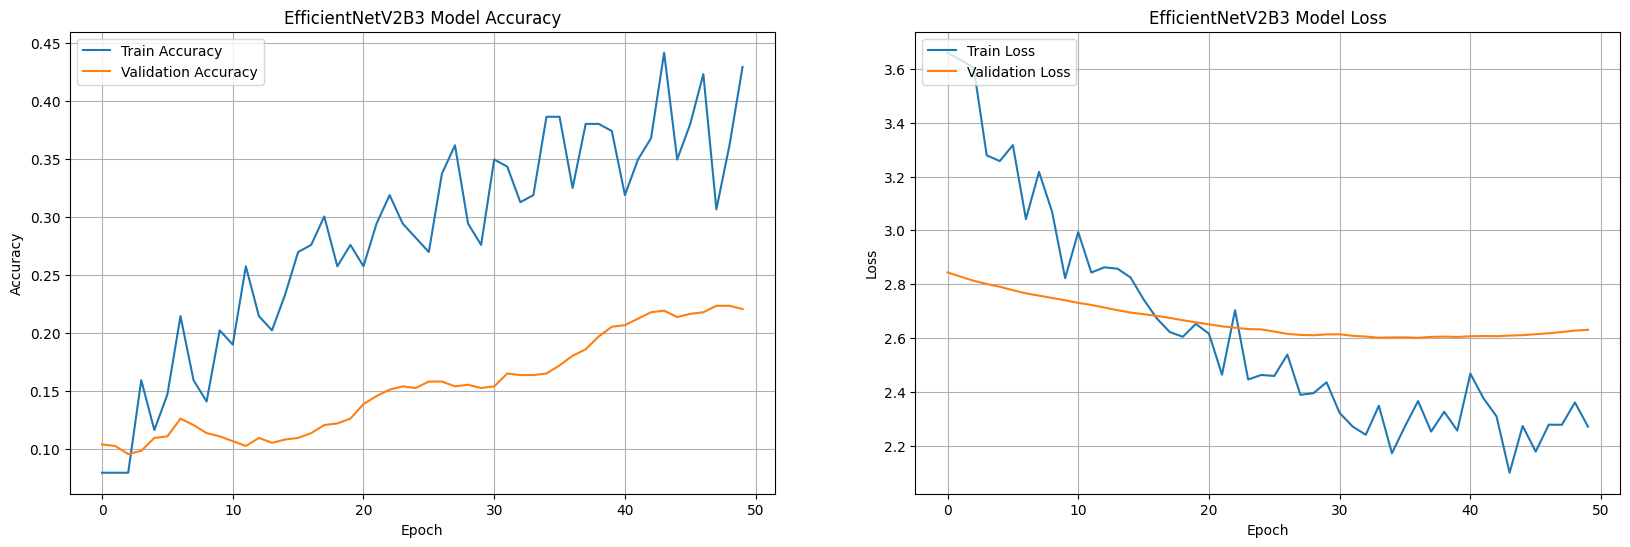

In [13]:
# Plotting accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('EfficientNetV2B3 Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('EfficientNetV2B3 Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

Found 360 images belonging to 12 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 718ms/step - accuracy: 0.1452 - loss: 2.5815
Loss: 2.5592234134674072
Accuracy: 0.20555555820465088
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 908ms/step

Metrics using sklearn:
Accuracy: 0.20555555555555555
Precision: 0.33223691023745633
Recall: 0.20555555555555555
F1 Score: 0.18016628893295134

Classification Report:
                           precision    recall  f1-score   support

 Acute & Chronic Rhinitis       0.75      0.10      0.18        30
Acute & Chronic Sinusitis       0.05      0.10      0.07        30
      Adenoid Hypertrophy       0.12      0.10      0.11        30
        Allergic Rhinitis       1.00      0.07      0.12        30
         Cavum Nasi Tumor       0.06      0.13      0.08        30
                   Concha       0.08      0.03      0.05        30
          Fallopian Tubes       0.25      0.07      0.11        30
                   Normal       0.51      0.63      0.57        30
       Normal 

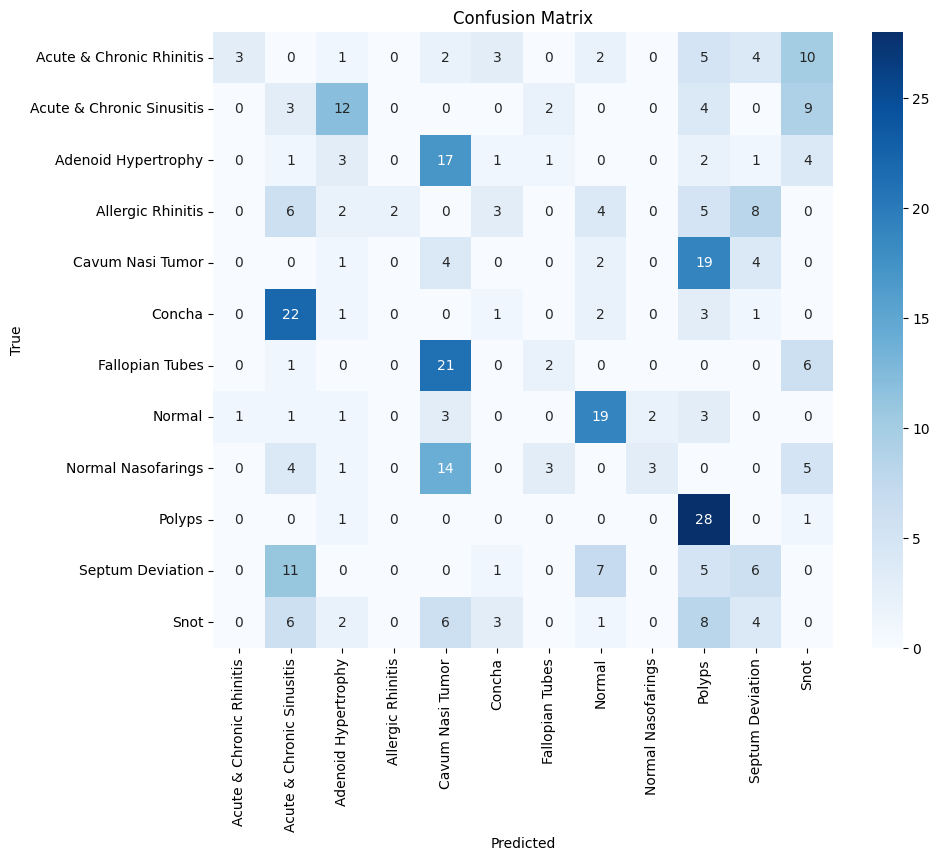

In [14]:
# Path ke model yang disimpan
model_path = 'C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\model\\EffNetV2B3.keras'

# Memuat model
model = load_model(model_path)

# Path ke direktori dataset
test_dir = "C:\\Users\\asusm\\Dropbox\\PC\\Downloads\\TA\\Split\\uji"

# Membuat objek ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = ImageDataGenerator(rescale=1.0/255)


# Load data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Pastikan shuffle dinonaktifkan untuk menjaga urutan data
)

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)

# Selesai menghitung waktu
end_time = time.perf_counter()

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Menghitung prediksi untuk data uji
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya dari test_generator
y_true = test_generator.classes

# Mendapatkan label class dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung metrik menggunakan sklearn
accuracy_sklearn = accuracy_score(y_true, y_pred)
precision_sklearn = precision_score(y_true, y_pred, average='weighted')
recall_sklearn = recall_score(y_true, y_pred, average='weighted')
f1_sklearn = f1_score(y_true, y_pred, average='weighted')

print("\nMetrics using sklearn:")
print(f"Accuracy: {accuracy_sklearn}")
print(f"Precision: {precision_sklearn}")
print(f"Recall: {recall_sklearn}")
print(f"F1 Score: {f1_sklearn}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
